# 18기 Clustering 정규세션 과제

## Clustering 해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. Clustering 
수업 내용 및 실습 자료를 참고하여 클러스터링을 자유롭게 진행해주세요. 한 알고리즘에 대해 파라미터를 바꿔가며 비교를 해도 되고, 여러 알고리즘의 결과를 비교해도 됩니다.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

## 0. 데이터 불러오기

(1) 구글 드라이브 연동하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(2) 필요한 module 불러오기

In [4]:
!pip install --upgrade kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import *
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

from kneed import KneeLocator

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial as sp 

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

(3) 데이터 불러오기

In [2]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/ToBigs/KNN/Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## 1. Preprocssing / EDA

### 1-1. 데이터 확인하기


(1) 데이터 이해하기


- `Gender` : 성별 (Female : 여성 / Male : 남성)
- `Age` : 나이
- `Annual Income` : 연봉
- `Spending Score` : 소비 관련 점수

(2) 전체 데이터 확인하기

In [7]:
df.shape

(200, 4)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [9]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [11]:
for col in df.columns:
    print(df[col].value_counts())
    print('*' * 50)

Female    112
Male       88
Name: Gender, dtype: int64
**************************************************
32    11
35     9
19     8
31     8
30     7
49     7
40     6
38     6
47     6
27     6
36     6
23     6
34     5
20     5
29     5
50     5
48     5
21     5
24     4
18     4
28     4
67     4
59     4
54     4
43     3
60     3
45     3
39     3
33     3
37     3
22     3
25     3
46     3
68     3
52     2
44     2
66     2
57     2
26     2
53     2
42     2
63     2
70     2
51     2
58     2
65     2
41     2
55     1
69     1
64     1
56     1
Name: Age, dtype: int64
**************************************************
54     12
78     12
48      6
71      6
63      6
       ..
58      2
59      2
16      2
64      2
137     2
Name: Annual Income (k$), Length: 64, dtype: int64
**************************************************
42    8
55    7
46    6
73    6
35    5
     ..
31    1
44    1
53    1
65    1
18    1
Name: Spending Score (1-100), Length: 84, dtype: int64
*****

(3) 결측치 확인하기

In [12]:
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

**Output**

결측치가 없다.

(4) 이상치 확인하기

In [13]:
# dataframe으로 변환
df = pd.DataFrame(df)

Text(0.5, 0.98, 'Histogram')

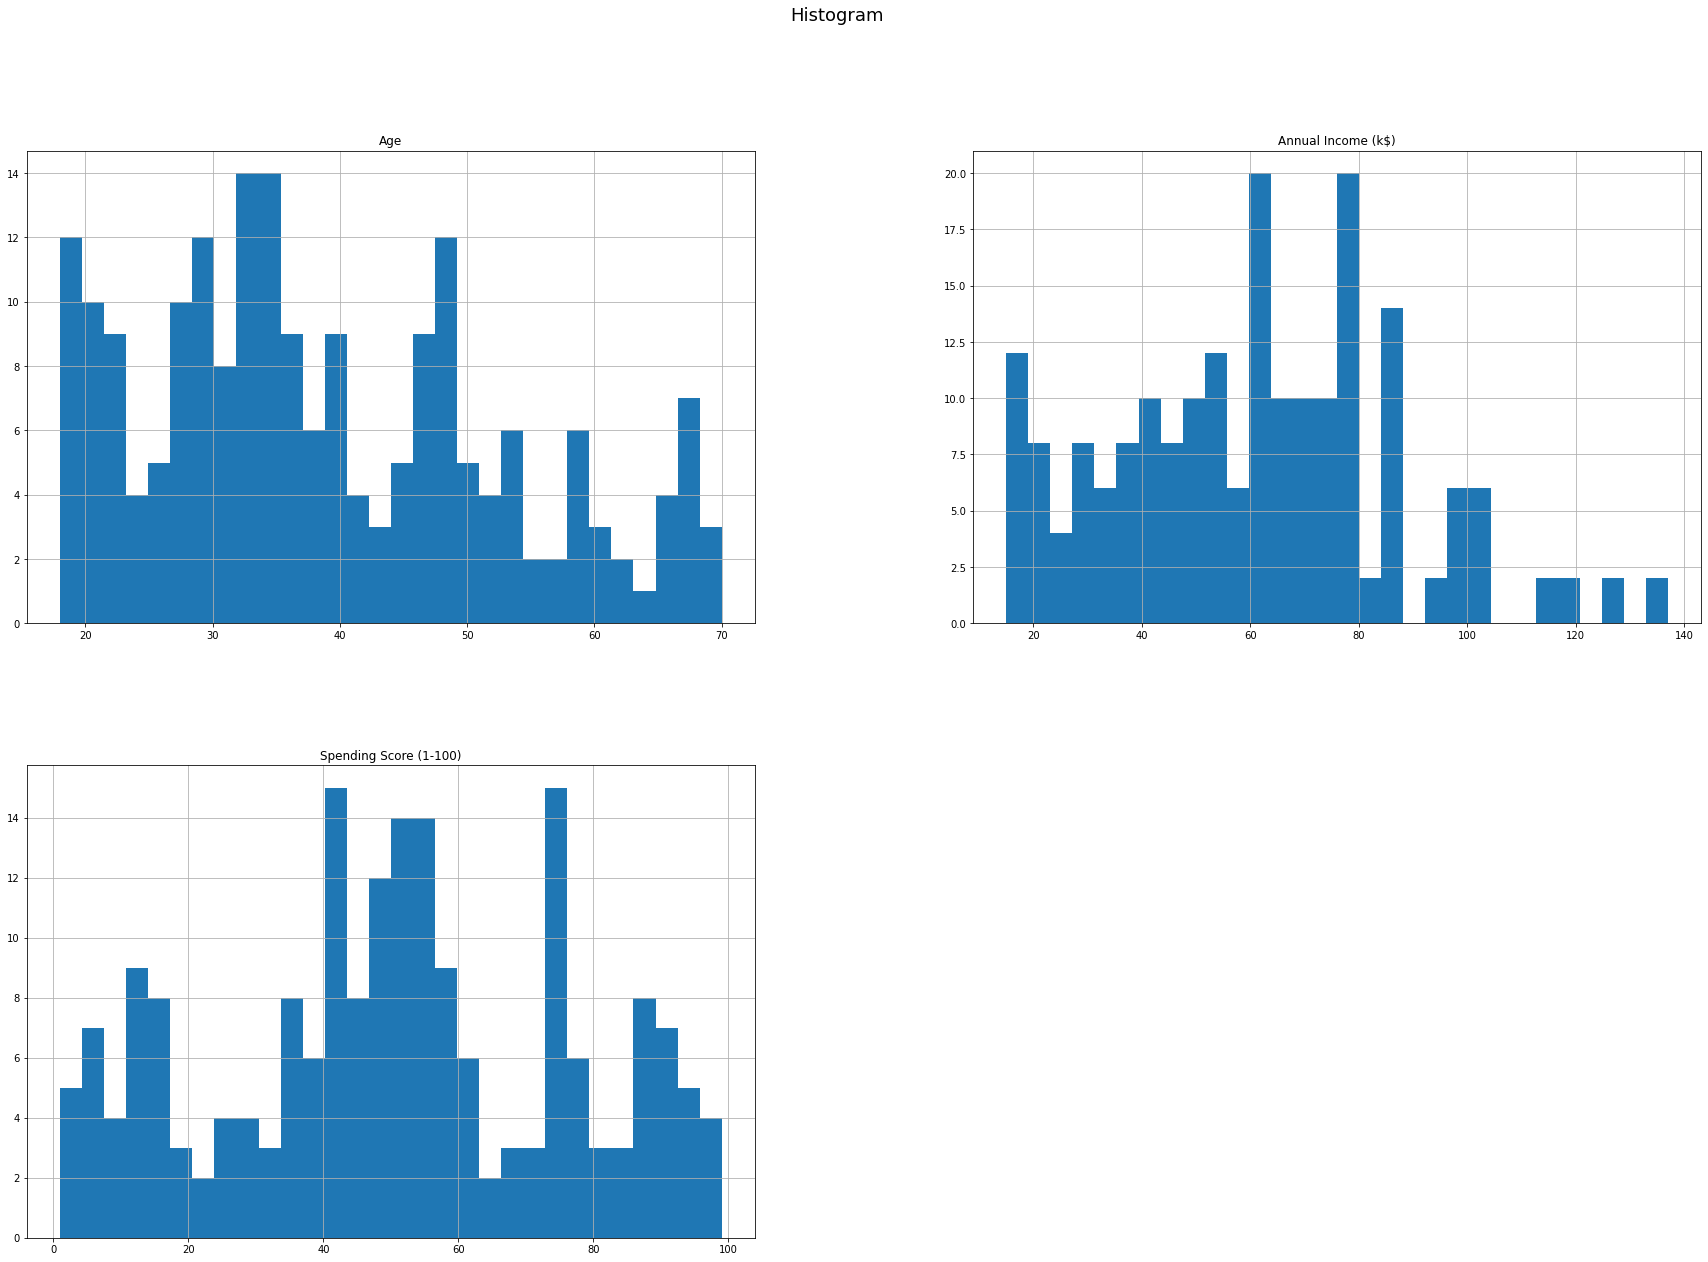

In [14]:
# 이상치 탐지
df.hist(bins=30, figsize=(30,20))
plt.suptitle("Histogram", fontsize=18)

**Output**

`Annual Income`에서 이상치가 보이는 것 같아, 따로 확인할 예정이다. 이외 각 항목에 대한 이상치가는 보이지 않는다.

- `Annual Income` 이상치 확인

In [38]:
px.histogram(df, x='Annual Income (k$)', color='Gender', marginal='box')

**Output**

`Annual income`에서 137,000$ 값이 이상치로 판단되므로, 이상치 제거를 진행해야한다.

### 1-2. 데이터 EDA하기

(1) 각 변수 간 상관관계 확인하기

In [20]:
# check correlation
df.corr()

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


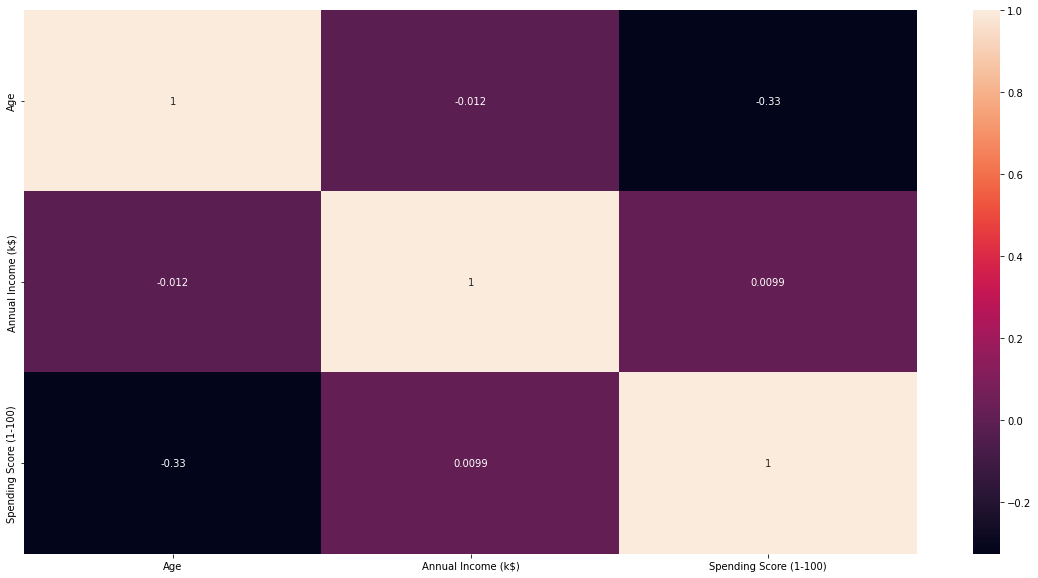

In [21]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True)

(2) 각 Column값 EDA하기

In [23]:
# Gender
fig = px.pie(values=df['Gender'].value_counts(), names=df['Gender'].value_counts().index, title='Gender')
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



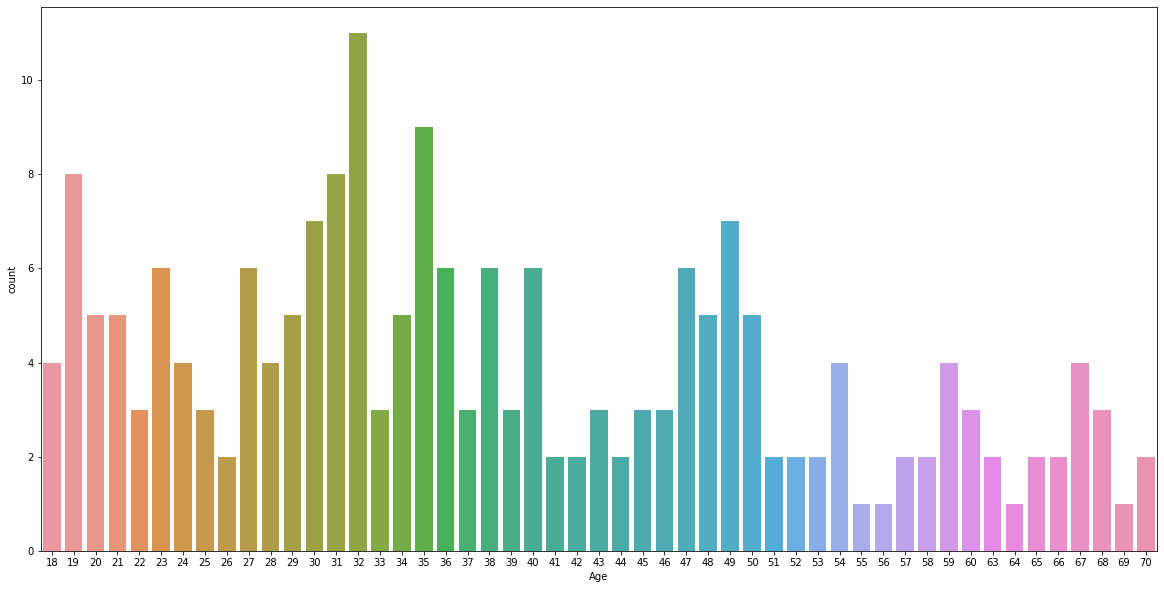

In [26]:
# Age 1
plt.figure(figsize= (20,10))
sns.countplot(df['Age'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



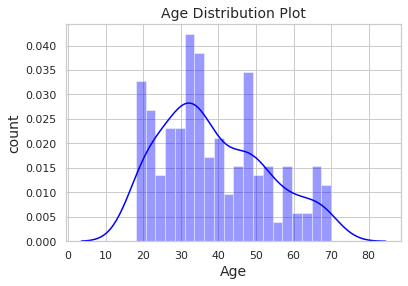

<Figure size 1440x720 with 0 Axes>

In [33]:
# Age 2
sns.set(style="whitegrid")
sns.distplot(df['Age'], color = "blue", bins=20)
plt.title("Age Distribution Plot", fontsize=14)
plt.xlabel("Age", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



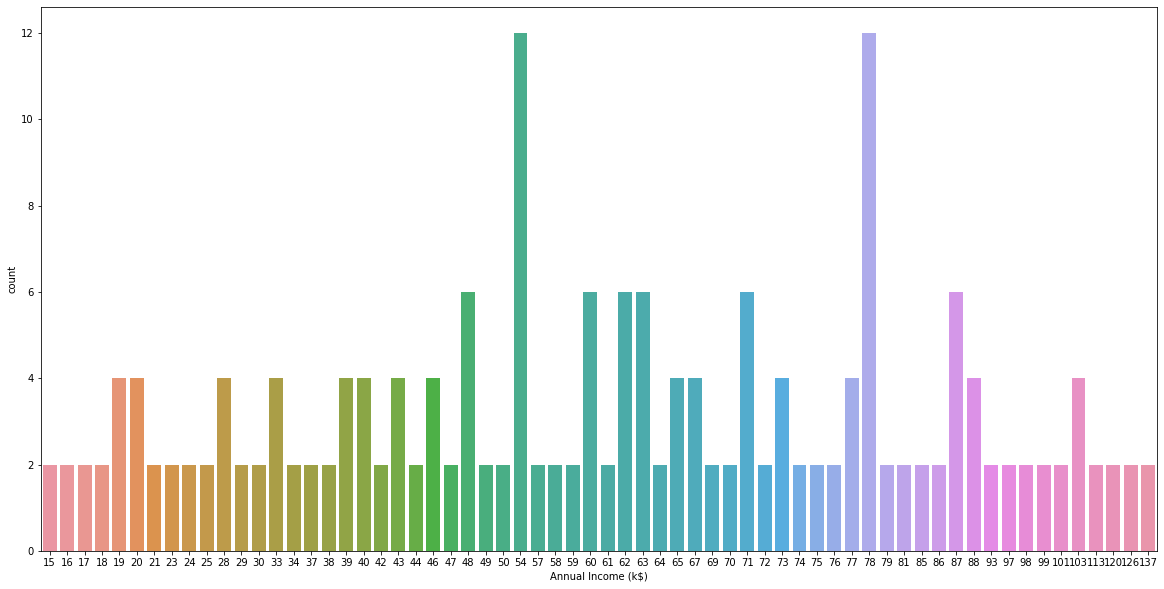

In [27]:
# Annual Income 1
plt.figure(figsize= (20,10))
sns.countplot(df['Annual Income (k$)'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



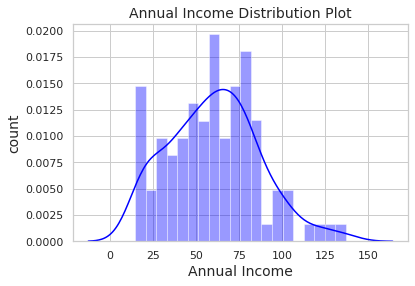

In [34]:
# Annual Income 2
sns.set(style="whitegrid")
sns.distplot(df['Annual Income (k$)'], color = "blue", bins=20)
plt.title("Annual Income Distribution Plot", fontsize=14)
plt.xlabel("Annual Income", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



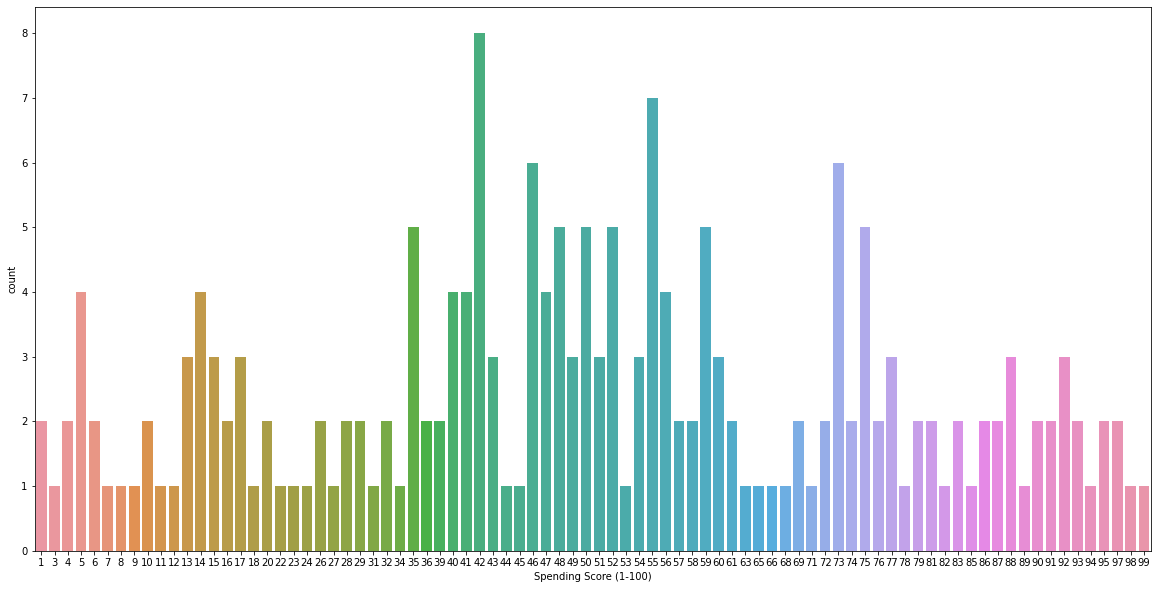

In [28]:
# Spending Score 1
plt.figure(figsize= (20,10))
sns.countplot(df['Spending Score (1-100)'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



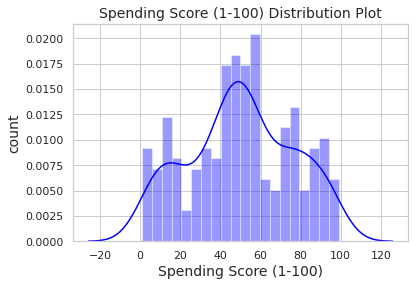

In [35]:
# Spending Score 2
sns.set(style="whitegrid")
sns.distplot(df['Spending Score (1-100)'], color = "blue", bins=20)
plt.title("Spending Score (1-100) Distribution Plot", fontsize=14)
plt.xlabel("Spending Score (1-100)", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.show()

(3) 서로 다른 변수들 EDA하기

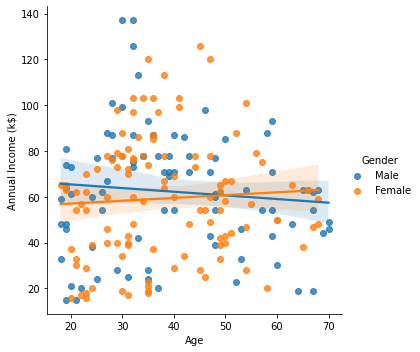

In [29]:
# Gender & Age & Annual Income
sns.lmplot(x="Age", y='Annual Income (k$)', data=df,  hue="Gender")

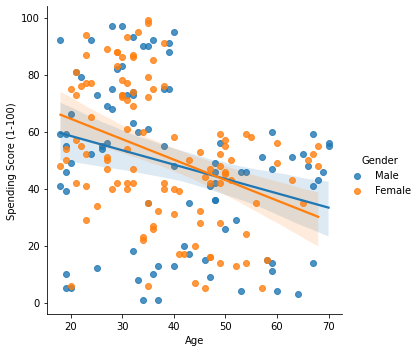

In [30]:
# Gender & Age & Spending Score
sns.lmplot(x="Age", y='Spending Score (1-100)', data=df, hue="Gender")

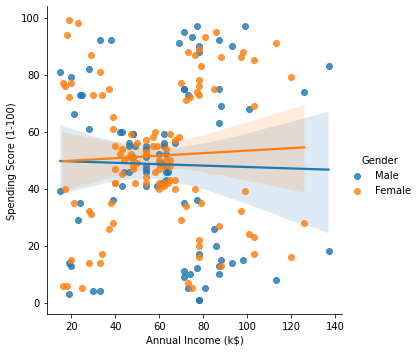

In [31]:
# Gender & Annual Income & Spending Score
sns.lmplot( x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue="Gender");

### 1-3. 데이터 전처리하기

(1) 데이터 인코딩하기

  `Gender`값을 Label Encoding 처리한다.

In [37]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,1,19,15,39
2,1,21,15,81
3,0,20,16,6
4,0,23,16,77
5,0,31,17,40


(2) 이상치 제거하기
  
  `Annual Income`에서 이상치인 137,000$을 제거한다. 

In [43]:
df.drop(df[df['Annual Income (k$)'] == 137].index , inplace=True)

## 2. Clustering

**K-means Clustering**

(1) Scaling하기



In [45]:
# scaling
scaler= StandardScaler().fit(df)
df_transformed =scaler.transform(df)

(2) 적절한 초기 K값 설정하기

- *Silhouette Coefficient*

In [47]:
# silhouette score
silhouette_scores = []

k = 20

for i in range(2, k):
    
    model=KMeans(n_clusters=i, random_state=42)
    model.fit(df_transformed)
    score = silhouette_score(df_transformed, model.labels_, metric='euclidean')
    silhouette_scores.append(score)

In [48]:
# silhouette score 그래프
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=list(range(2,k)), y=silhouette_scores, name="silhouette_scores", mode="lines"),
    secondary_y=True
)

fig.update_xaxes(title_text="number of clusters")
fig.update_yaxes(title_text="silhouette_scores", secondary_y=True)

**Output**

**K = 10**일때 가장 적절한 cluster값으로 설정하였다.

(3) K-means Clustering 모델 구현하기

In [49]:
# modeling
model=KMeans(n_clusters=10, random_state=42)
model.fit(df_transformed)

KMeans(n_clusters=10, random_state=42)

In [51]:
df_transformed = scaler.inverse_transform(df_transformed)
df_transformed = pd.DataFrame(df_transformed)
df_transformed.columns = df.columns
df_transformed['labels'] = model.labels_
df_transformed['labels'] = df_transformed['labels'].astype(str)

## 3. Evaluation

In [52]:
# 시각화하기
px.scatter_3d(df_transformed , x='Annual Income (k$)' ,
              y='Spending Score (1-100)', z= 'Age',color='labels')